In [82]:
%load_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn.functional as F

import sys
sys.path.append('../')
import os

from cont_speech_experiment import ContinuousSpeechExperiment, ClasswiseDataset
from nupic.research.support import parse_config
from cl_utils import train_model, train_multi_model, unravel_index

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
data_dir = "/home/ec2-user/nta/data/data_classes/"
test_dir = "/home/ec2-user/nta/data/"
config_file = "../experiments.cfg"
exp = "sparseCNN2"
config_init = parse_config(config_file)
config = config_init[exp]
config["name"] = exp
config["seed"] = np.random.randint(0,200)
config["data_dir"] = data_dir
config["batch_size"] = 32
config["num_classes"] = 11
config["freeze_params"] = "output"

# config["boost_strength"] = 0.0
# config["boost_strength_factor"] = 0.0

experiment = ContinuousSpeechExperiment(config=config)

model on GPU
Creating optimizer with learning rate= 0.01


In [30]:
model = experiment.model
f = experiment.combine_classes([2,4])

In [31]:
loader = experiment.train_loader

In [32]:
xs, ys = [], []
for x, y in loader:
    xs.append(x.cuda())
    ys.append(y.cuda())

In [33]:
f.close()

In [7]:
criterion = F.nll_loss
opt = torch.optim.SGD(model.parameters(), lr=0.1)
opt.zero_grad()

loss = criterion(model(xs[0]), ys[0])
loss.backward()

In [8]:
weights = list(model.parameters())
weights[2].shape

torch.Size([64, 64, 5, 5])

In [10]:
def k_grad(module, pct):
    
    k = int(pct/100 * module.numel())
    xr = module.grad.reshape(1,-1)
    xr_abs = torch.abs(xr)
    s, inds = torch.topk(xr_abs, k, sorted=False)
    grs = xr[:,inds]
    res = torch.zeros_like(xr)
    res.scatter_(1,inds,xr.gather(1,inds))
    res = res.reshape(module.grad.shape)
    
    module.grad = res

In [47]:
module = weights[2]
pct = 2

k = int(pct/100 * module.numel())
xr = module.grad.reshape(1,-1)
xr_abs = torch.abs(xr)
s, inds = torch.topk(xr_abs, k, sorted=False)
grs = xr[:,inds]
res = torch.zeros_like(xr)
res.scatter_(1,inds,xr.gather(1,inds))
res = res.reshape(module.grad.shape)

module.grad = res

In [11]:
for w in weights:
    try:
        k_grad(w, 2)
    except:
        pass

In [77]:
experiment = ContinuousSpeechExperiment(config=config)

model = experiment.model
criterion = F.nll_loss
opt = torch.optim.SGD(model.parameters(), lr=0.1)
opt.zero_grad()

loss = criterion(model(xs[0]), ys[0])
loss.backward()

weights = list(model.parameters())
module = weights[2]
pct = 2
k = int(pct/100 * module.numel())
xr = module.grad.reshape(1,-1)
xr_abs = torch.abs(xr)
s, inds = torch.topk(xr_abs, k, sorted=False)
grs = xr[:,inds]
res = torch.zeros_like(xr)
res.scatter_(1,inds,xr.gather(1,inds))
res = res.reshape(module.grad.shape)

weights[2].grad = res

opt.step()

model on GPU
Creating optimizer with learning rate= 0.01


In [87]:
train_labels[0]

array([2, 4])

In [90]:
train_labels = np.reshape(np.random.permutation(np.arange(1,11)), (5,2))
label = train_labels[0]
indices = np.hstack([0,np.delete(train_labels,np.where(train_labels==label)[0],axis=0).flatten()])
experiment.train(1, train_labels, indices)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ec2-user/nta/data/data_classes/data_train_[10  3].npz'

In [ ]:
experiment.tr

In [12]:
train_model(model, loader, experiment.optimizer, experiment.device,
            batches_in_epoch=experiment.batches_in_epoch)

In [79]:
# weights = list(model.parameters())
n_weights = [k.detach().cpu().numpy() for k in weights]
g_weights = [k.grad.detach().cpu().numpy() for k in weights]

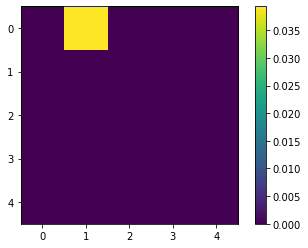

In [81]:
plt.imshow(g_weights[2][4,0,:,:])
plt.colorbar()

In [70]:
a = weights[2].grad.detach().cpu().numpy()
a.shape

(64, 64, 5, 5)

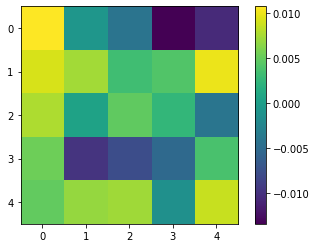

In [72]:
plt.imshow(a[0,0,:,:])
plt.colorbar()

In [74]:
res.dtype

torch.float32